1. Import Library & Konfigurasi
2. Load & Split Dataset
3. Data Loader & Preprocessing
4. Model 1: CNN Base (Non-Pretrained)
5. Evaluasi CNN Base
6. Model 2: Transfer Learning (ResNet50)
7. Evaluasi ResNet50
8. Model 3: Transfer Learning (MobileNetV2)
9. Evaluasi MobileNetV2
10. Perbandingan Hasil Model

In [4]:
import os, shutil, random
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import classification_report, confusion_matrix

e:\ModulS7\UAP\.venv\Lib\site-packages\keras\src\export\tf2onnx_lib.py:8: FutureWarning: In the future `np.object` will be defined as the corresponding NumPy scalar.
  if not hasattr(np, "object"):


SPLIT DATASET

In [3]:
BASE_DIR = r"E:\ModulS7\UAP"
SOURCE = os.path.join(BASE_DIR, "DatasetUAP")
TARGET = os.path.join(BASE_DIR, "data")

random.seed(42)

for cls in os.listdir(SOURCE):
    imgs = os.listdir(os.path.join(SOURCE, cls))
    random.shuffle(imgs)

    n = len(imgs)
    train = imgs[:int(0.7*n)]
    val = imgs[int(0.7*n):int(0.85*n)]
    test = imgs[int(0.85*n):]

    for split, files in zip(["train","val","test"], [train,val,test]):
        dst = os.path.join(TARGET, split, cls)
        os.makedirs(dst, exist_ok=True)
        for f in files:
            shutil.copy(
                os.path.join(SOURCE, cls, f),
                os.path.join(dst, f)
            )

EDA

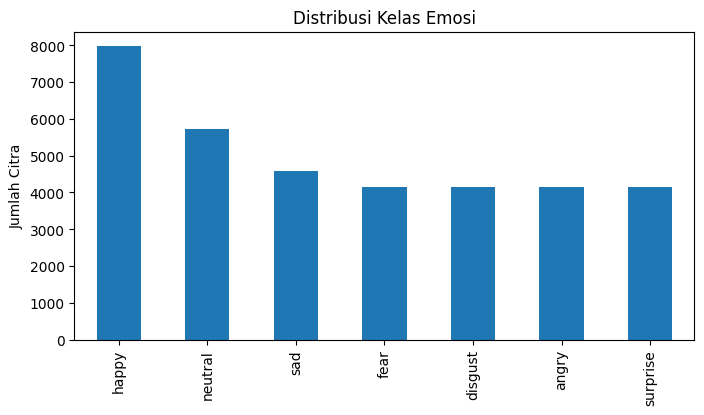

In [24]:
import pandas as pd

DATA_DIR = r"E:\ModulS7\UAP\data\train"

class_counts = {
    cls: len(os.listdir(os.path.join(DATA_DIR, cls)))
    for cls in os.listdir(DATA_DIR)
}

df_counts = pd.DataFrame.from_dict(class_counts, orient='index', columns=['count'])
df_counts = df_counts.sort_values(by='count', ascending=False)
df_counts

df_counts.plot(kind='bar', legend=False, figsize=(8,4))
plt.title("Distribusi Kelas Emosi")
plt.ylabel("Jumlah Citra")
plt.show()

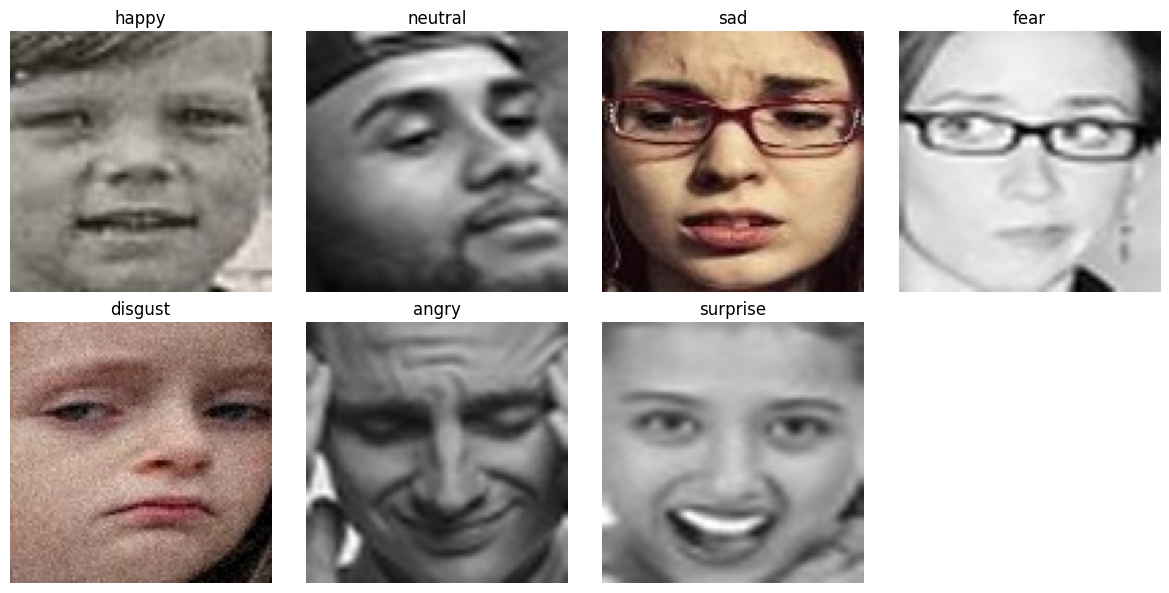

In [25]:
from PIL import Image
import random

plt.figure(figsize=(12,6))
for i, cls in enumerate(df_counts.index):
    img_path = os.path.join(DATA_DIR, cls)
    img_name = random.choice(os.listdir(img_path))
    img = Image.open(os.path.join(img_path, img_name))

    plt.subplot(2, 4, i+1)
    plt.imshow(img)
    plt.title(cls)
    plt.axis("off")

plt.tight_layout()
plt.show()

DATA LOADER

In [28]:
BASE_DIR = r"E:\ModulS7\UAP"
TARGET = os.path.join(BASE_DIR, "data")

def load_data(img_size=(224,224), batch_size=32):
    train_ds = tf.keras.preprocessing.image_dataset_from_directory(
        os.path.join(TARGET, "train"),
        image_size=img_size,
        batch_size=batch_size,
        color_mode="rgb"   # 🔥 PENTING
    )

    val_ds = tf.keras.preprocessing.image_dataset_from_directory(
        os.path.join(TARGET, "val"),
        image_size=img_size,
        batch_size=batch_size,
        color_mode="rgb"
    )

    test_ds = tf.keras.preprocessing.image_dataset_from_directory(
        os.path.join(TARGET, "test"),
        image_size=img_size,
        batch_size=batch_size,
        shuffle=False,
        color_mode="rgb"
    )

    class_names = train_ds.class_names
    return train_ds, val_ds, test_ds, class_names

DATA AUGMENTATION

In [35]:
data_augmentation = tf.keras.Sequential(
    [
        tf.keras.layers.RandomFlip("horizontal"),
        tf.keras.layers.RandomRotation(0.05),
        tf.keras.layers.RandomZoom(0.1),
        tf.keras.layers.RandomContrast(0.1),
    ],
    name="data_augmentation"
)

class weight

In [36]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_true),
    y=y_true
)

class_weight_dict = dict(enumerate(class_weights))
class_weight_dict

{0: np.float64(1.2014157014157014),
 1: np.float64(1.2014157014157014),
 2: np.float64(1.2014157014157014),
 3: np.float64(0.6238930659983292),
 4: np.float64(0.8709037900874635),
 5: np.float64(1.0875200232998399),
 6: np.float64(1.2014157014157014)}

MODEL 1 — CNN BASE (NON-PRETRAINED)

In [49]:
train_ds, val_ds, test_ds, class_names = load_data()

model_cnn = tf.keras.Sequential([
    data_augmentation,                        
    tf.keras.layers.Rescaling(1./255, input_shape=(224,224,3)),

    tf.keras.layers.Conv2D(32, 3, activation='relu'),
    tf.keras.layers.MaxPooling2D(),

    tf.keras.layers.Conv2D(64, 3, activation='relu'),
    tf.keras.layers.MaxPooling2D(),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(len(class_names), activation='softmax')
], name="CNN_Base_Aug")

model_cnn.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

history_cnn = model_cnn.fit(
    train_ds,
    validation_data=val_ds,
    epochs=20,
    class_weight=class_weight_dict
)

os.makedirs("models", exist_ok=True)
model_cnn.save("models/cnn_base_New.keras")

Found 34844 files belonging to 7 classes.
Found 7467 files belonging to 7 classes.
Found 7468 files belonging to 7 classes.
Epoch 1/20


e:\ModulS7\UAP\.venv\Lib\site-packages\keras\src\layers\preprocessing\data_layer.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1089/1089 ━━━━━━━━━━━━━━━━━━━━ 308s 282ms/step - accuracy: 0.3331 - loss: 1.6983 - val_accuracy: 0.4561 - val_loss: 1.4031
Epoch 2/20
1089/1089 ━━━━━━━━━━━━━━━━━━━━ 311s 286ms/step - accuracy: 0.4584 - loss: 1.4262 - val_accuracy: 0.4979 - val_loss: 1.3164
Epoch 3/20
1089/1089 ━━━━━━━━━━━━━━━━━━━━ 311s 286ms/step - accuracy: 0.4962 - loss: 1.3301 - val_accuracy: 0.5311 - val_loss: 1.2277
Epoch 4/20
1089/1089 ━━━━━━━━━━━━━━━━━━━━ 310s 284ms/step - accuracy: 0.5187 - loss: 1.2778 - val_accuracy: 0.5385 - val_loss: 1.2038
Epoch 5/20
1089/1089 ━━━━━━━━━━━━━━━━━━━━ 311s 286ms/step - accuracy: 0.5375 - loss: 1.2261 - val_accuracy: 0.5532 - val_loss: 1.1687
Epoch 6/20
1089/1089 ━━━━━━━━━━━━━━━━━━━━ 310s 285ms/step - accuracy: 0.5494 - loss: 1.2037 - val_accuracy: 0.5469 - val_loss: 1.1809
Epoch 7/20
1089/1089 ━━━━━━━━━━━━━━━━━━━━ 308s 283ms/step - accuracy: 0.5636 - loss: 1.1689 - val_accuracy: 0.5645 - val_loss: 1.1572
Epoch 8/20
1089/1089 ━━━━━━━━━━━━━━━━━━━━ 308s 283ms/step - accuracy: 0.5

EVALUASI

In [50]:
from sklearn.metrics import classification_report, accuracy_score

# True label & prediksi
y_true = np.concatenate([y for _, y in test_ds])
y_pred = np.argmax(model_cnn.predict(test_ds), axis=1)

# Accuracy eksplisit
acc = accuracy_score(y_true, y_pred)
print(f"Akurasi CNN Base: {acc:.4f}")

# Classification report
print("\nClassification Report (CNN Base):")
print(classification_report(y_true, y_pred, target_names=class_names))

234/234 ━━━━━━━━━━━━━━━━━━━━ 11s 48ms/step
Akurasi CNN Base: 0.5990

Classification Report (CNN Base):
              precision    recall  f1-score   support

       angry       0.42      0.38      0.40       888
     disgust       0.73      0.82      0.77       888
        fear       0.45      0.38      0.41       888
       happy       0.83      0.77      0.80      1710
     neutral       0.53      0.54      0.53      1225
         sad       0.41      0.54      0.47       981
    surprise       0.73      0.62      0.67       888

    accuracy                           0.60      7468
   macro avg       0.58      0.58      0.58      7468
weighted avg       0.61      0.60      0.60      7468



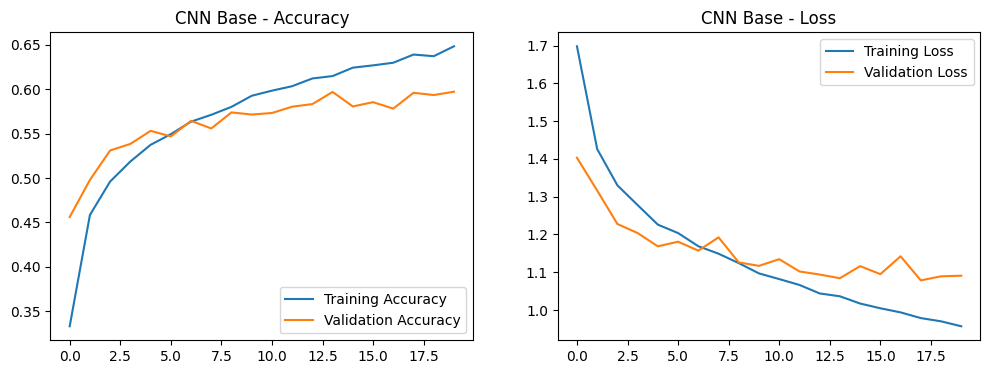

In [52]:
acc = history_cnn.history['accuracy']
val_acc = history_cnn.history['val_accuracy']

loss = history_cnn.history['loss']
val_loss = history_cnn.history['val_loss']

epochs_range = range(len(acc))

plt.figure(figsize=(12,4))

# Accuracy
plt.subplot(1,2,1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('CNN Base - Accuracy')

# Loss
plt.subplot(1,2,2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('CNN Base - Loss')

plt.show()

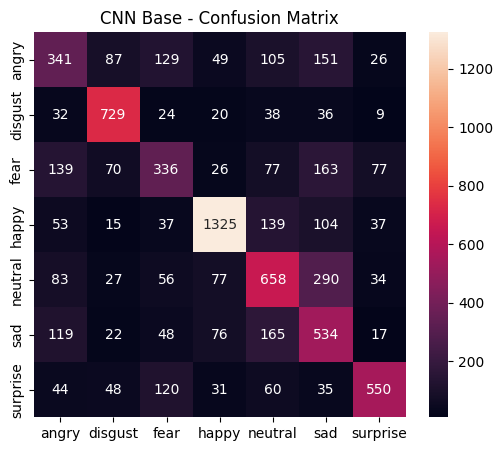

In [51]:
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d",
            xticklabels=class_names,
            yticklabels=class_names)
plt.title("CNN Base - Confusion Matrix")
plt.show()

MODEL 2 — RESNET50

In [40]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input

# ===== BASE MODEL =====
base_model = ResNet50(
    weights="imagenet",
    include_top=False,
    input_shape=(224,224,3)
)
base_model.trainable = False

# ===== MODEL =====
inputs = tf.keras.Input(shape=(224,224,3))

x = data_augmentation(inputs)        # 🔥 AUGMENTASI
x = preprocess_input(x)
x = base_model(x, training=False)

x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dense(128, activation='relu')(x)
outputs = tf.keras.layers.Dense(len(class_names), activation='softmax')(x)

model_resnet = tf.keras.Model(inputs, outputs, name="ResNet50_Aug")

model_resnet.summary()

Model: "ResNet50_Aug"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_11      │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ data_augmentation   │ (None, 224, 224,  │          0 │ input_layer_11[0… │
│ (Sequential)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_3          │ (None, 224, 224)  │          0 │ data_augmentatio… │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_4          │ (None, 224, 224)  │          0 │ data_augmentatio… │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_5          │ (None, 224, 224)  │          0 │ data_augmentatio… │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stack_1 (Stack)     │ (None, 224, 224,  │          0 │ get_item_3[0][0], │
│                     │ 3)                │            │ get_item_4[0][0], │
│                     │                   │            │ get_item_5[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, 224, 224,  │          0 │ stack_1[0][0]     │
│                     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ resnet50            │ (None, 7, 7,      │ 23,587,712 │ add_1[0][0]       │
│ (Functional)        │ 2048)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 2048)      │          0 │ resnet50[0][0]    │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_12 (Dense)    │ (None, 128)       │    262,272 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_13 (Dense)    │ (None, 7)         │        903 │ dense_12[0][0]    │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 23,850,887 (90.98 MB)

 Trainable params: 263,175 (1.00 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

Compile & Train

In [41]:
model_resnet.compile(
    optimizer=tf.keras.optimizers.Adam(1e-4),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

history_resnet = model_resnet.fit(
    train_ds,
    validation_data=val_ds,
    epochs=15,
    class_weight=class_weight_dict
)

os.makedirs("models", exist_ok=True)
model_resnet.save("models/resnet50_New.keras")

Epoch 1/15
1089/1089 ━━━━━━━━━━━━━━━━━━━━ 1259s 1s/step - accuracy: 0.4454 - loss: 1.4687 - val_accuracy: 0.5176 - val_loss: 1.2995
Epoch 2/15
1089/1089 ━━━━━━━━━━━━━━━━━━━━ 1140s 1s/step - accuracy: 0.5251 - loss: 1.2857 - val_accuracy: 0.5432 - val_loss: 1.2339
Epoch 3/15
1089/1089 ━━━━━━━━━━━━━━━━━━━━ 817s 750ms/step - accuracy: 0.5526 - loss: 1.2219 - val_accuracy: 0.5409 - val_loss: 1.2170
Epoch 4/15
1089/1089 ━━━━━━━━━━━━━━━━━━━━ 828s 761ms/step - accuracy: 0.5664 - loss: 1.1796 - val_accuracy: 0.5607 - val_loss: 1.1668
Epoch 5/15
1089/1089 ━━━━━━━━━━━━━━━━━━━━ 782s 718ms/step - accuracy: 0.5790 - loss: 1.1488 - val_accuracy: 0.5674 - val_loss: 1.1520
Epoch 6/15
1089/1089 ━━━━━━━━━━━━━━━━━━━━ 689s 633ms/step - accuracy: 0.5885 - loss: 1.1232 - val_accuracy: 0.5622 - val_loss: 1.1488
Epoch 7/15
1089/1089 ━━━━━━━━━━━━━━━━━━━━ 687s 631ms/step - accuracy: 0.5967 - loss: 1.1046 - val_accuracy: 0.5842 - val_loss: 1.1206
Epoch 8/15
1089/1089 ━━━━━━━━━━━━━━━━━━━━ 687s 631ms/step - accura

Evaluasi ResNet50

In [42]:
from sklearn.metrics import classification_report, accuracy_score

# True label & prediksi
y_true = np.concatenate([y for _, y in test_ds])
y_pred = np.argmax(model_resnet.predict(test_ds), axis=1)

# Accuracy eksplisit
acc_resnet = accuracy_score(y_true, y_pred)
print(f"=== RESNET50 ===")
print(f"Akurasi ResNet50: {acc_resnet:.4f}")

# Classification report
print("\nClassification Report (ResNet50):")
print(classification_report(y_true, y_pred, target_names=class_names))

234/234 ━━━━━━━━━━━━━━━━━━━━ 119s 506ms/step
=== RESNET50 ===
Akurasi ResNet50: 0.6000

Classification Report (ResNet50):
              precision    recall  f1-score   support

       angry       0.56      0.31      0.40       888
     disgust       0.87      0.66      0.75       888
        fear       0.42      0.50      0.46       888
       happy       0.81      0.74      0.77      1710
     neutral       0.54      0.63      0.58      1225
         sad       0.42      0.57      0.48       981
    surprise       0.64      0.66      0.65       888

    accuracy                           0.60      7468
   macro avg       0.61      0.58      0.58      7468
weighted avg       0.62      0.60      0.60      7468



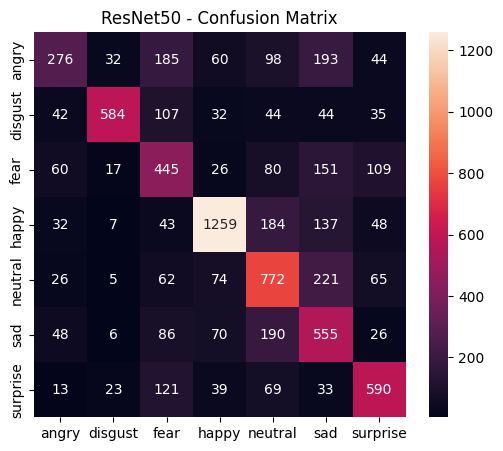

In [43]:
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d",
            xticklabels=class_names,
            yticklabels=class_names)
plt.title("ResNet50 - Confusion Matrix")
plt.show()

MODEL 3 — MOBILENETV2

In [44]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input

# ===== BASE MODEL =====
base_model = MobileNetV2(
    weights="imagenet",
    include_top=False,
    input_shape=(224,224,3)
)
base_model.trainable = False

# ===== MODEL =====
inputs = tf.keras.Input(shape=(224,224,3))

x = data_augmentation(inputs)        # 🔥 AUGMENTASI
x = preprocess_input(x)
x = base_model(x, training=False)

x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dense(128, activation='relu')(x)
outputs = tf.keras.layers.Dense(len(class_names), activation='softmax')(x)

model_mobilenet = tf.keras.Model(inputs, outputs, name="MobileNetV2_Aug")

model_mobilenet.summary()

Model: "MobileNetV2_Aug"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_13 (InputLayer)     │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ data_augmentation (Sequential)  │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ true_divide_1 (TrueDivide)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ subtract_1 (Subtract)           │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_3      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 7)              │           903 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,422,855 (9.24 MB)

 Trainable params: 164,871 (644.03 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

Compile & Train

In [45]:
model_mobilenet.compile(
    optimizer=tf.keras.optimizers.Adam(1e-4),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

history_mobilenet = model_mobilenet.fit(
    train_ds,
    validation_data=val_ds,
    epochs=15,
    class_weight=class_weight_dict
)

model_mobilenet.save("models/mobilenetv2_New.keras")

Epoch 1/15
1089/1089 ━━━━━━━━━━━━━━━━━━━━ 213s 193ms/step - accuracy: 0.4094 - loss: 1.5366 - val_accuracy: 0.4515 - val_loss: 1.4638
Epoch 2/15
1089/1089 ━━━━━━━━━━━━━━━━━━━━ 221s 203ms/step - accuracy: 0.4852 - loss: 1.3780 - val_accuracy: 0.4908 - val_loss: 1.3696
Epoch 3/15
1089/1089 ━━━━━━━━━━━━━━━━━━━━ 222s 204ms/step - accuracy: 0.5033 - loss: 1.3296 - val_accuracy: 0.4946 - val_loss: 1.3452
Epoch 4/15
1089/1089 ━━━━━━━━━━━━━━━━━━━━ 225s 206ms/step - accuracy: 0.5175 - loss: 1.2945 - val_accuracy: 0.5124 - val_loss: 1.3138
Epoch 5/15
1089/1089 ━━━━━━━━━━━━━━━━━━━━ 226s 208ms/step - accuracy: 0.5302 - loss: 1.2729 - val_accuracy: 0.5145 - val_loss: 1.3203
Epoch 6/15
1089/1089 ━━━━━━━━━━━━━━━━━━━━ 229s 211ms/step - accuracy: 0.5382 - loss: 1.2554 - val_accuracy: 0.5282 - val_loss: 1.2662
Epoch 7/15
1089/1089 ━━━━━━━━━━━━━━━━━━━━ 227s 208ms/step - accuracy: 0.5432 - loss: 1.2372 - val_accuracy: 0.5235 - val_loss: 1.2781
Epoch 8/15
1089/1089 ━━━━━━━━━━━━━━━━━━━━ 223s 205ms/step - ac

Evaluasi MobileNetV2

In [46]:
from sklearn.metrics import classification_report, accuracy_score

# True label & prediksi
y_true = np.concatenate([y for _, y in test_ds])
y_pred = np.argmax(model_mobilenet.predict(test_ds), axis=1)

# Accuracy eksplisit
acc_mobilenet = accuracy_score(y_true, y_pred)
print("=== MOBILENETV2 ===")
print(f"Akurasi MobileNetV2: {acc_mobilenet:.4f}")

# Classification report
print("\nClassification Report (MobileNetV2):")
print(classification_report(y_true, y_pred, target_names=class_names))

234/234 ━━━━━━━━━━━━━━━━━━━━ 40s 170ms/step
=== MOBILENETV2 ===
Akurasi MobileNetV2: 0.5311

Classification Report (MobileNetV2):
              precision    recall  f1-score   support

       angry       0.39      0.37      0.38       888
     disgust       0.75      0.69      0.72       888
        fear       0.38      0.43      0.40       888
       happy       0.82      0.56      0.67      1710
     neutral       0.45      0.61      0.52      1225
         sad       0.38      0.45      0.41       981
    surprise       0.61      0.57      0.59       888

    accuracy                           0.53      7468
   macro avg       0.54      0.52      0.53      7468
weighted avg       0.56      0.53      0.54      7468



GRAFIK LOSS & ACCURACY

In [47]:
def plot_history(history, title):
    plt.figure(figsize=(10,4))

    plt.subplot(1,2,1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title(f'{title} Accuracy')
    plt.legend(['Train','Val'])

    plt.subplot(1,2,2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title(f'{title} Loss')
    plt.legend(['Train','Val'])

    plt.show()

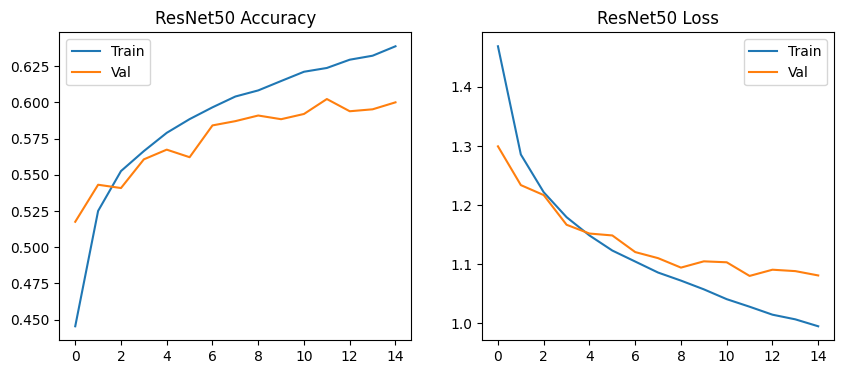

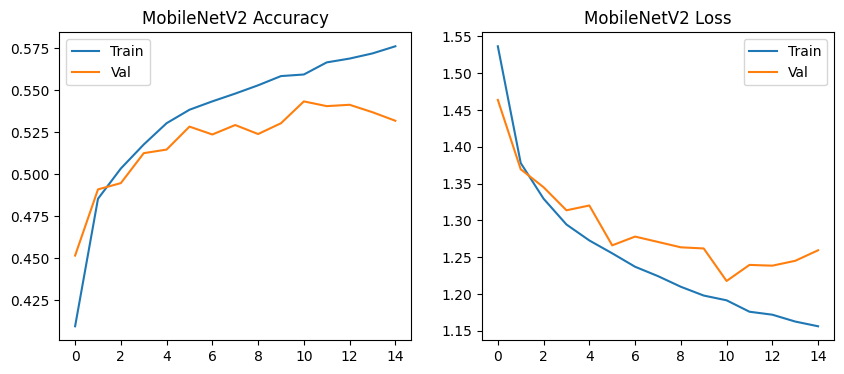

In [48]:
plot_history(history_resnet, "ResNet50")
plot_history(history_mobilenet, "MobileNetV2")